In [155]:
import yfinance as yf
import pandas as pd

ticker = 'F'  # apple

# data = yf.download(ticker, start='1980-03-17', end='2020-05-24', group_by='ticker')

# # Bỏ MultiIndex trong columns
# data.columns = data.columns.get_level_values(1)  # giữ lại chỉ tên cột (AAPL)
# print(data.columns)

# data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
# # print(data.isna().sum())
# data.dropna(inplace=True)

# data.head()

In [156]:
data = pd.read_csv("./data/stocks/F.csv", sep=',')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data.dropna(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1991-04-12,20.000,23.500,20.000,22.750,12.792336,482100
1991-04-15,23.125,26.125,23.125,26.000,14.619807,392800
1991-04-16,26.000,26.375,25.000,25.125,14.127795,384300
1991-04-17,25.500,26.250,25.500,25.750,14.479237,205400
1991-04-18,25.750,27.375,25.750,26.625,14.971251,214000


In [157]:
from ta.trend import SMAIndicator, EMAIndicator, MACD, ADXIndicator, CCIIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator

# Chuẩn hóa dữ liệu Close
close_series = data['Close'].squeeze()

# Trung bình động
data['MA20'] = SMAIndicator(close=close_series, window=20).sma_indicator()
data['EMA10'] = EMAIndicator(close=close_series, window=10).ema_indicator()

# RSI
data['RSI'] = RSIIndicator(close=close_series).rsi()

# Stochastic chỉ lấy %K
stoch = StochasticOscillator(close=close_series, high=data['High'].squeeze(), low=data['Low'].squeeze())
data['Stoch_%K'] = stoch.stoch()

# MACD chỉ lấy Diff (tín hiệu mạnh)
macd = MACD(close=close_series)
data['MACD_Diff'] = macd.macd_diff()

# Bollinger Bands chỉ giữ độ rộng
bb = BollingerBands(close=close_series)
data['BB_Width'] = bb.bollinger_wband()
data['BB_%B'] = bb.bollinger_pband()

# ADX và các chỉ số liên quan
adx = ADXIndicator(high=data['High'], low=data['Low'], close=close_series)
data['ADX'] = adx.adx()
data['+DI'] = adx.adx_pos()
data['-DI'] = adx.adx_neg()

# Chỉ báo mới bổ sung
data['CCI'] = CCIIndicator(high=data['High'], low=data['Low'], close=close_series).cci()
data['ATR'] = AverageTrueRange(high=data['High'], low=data['Low'], close=close_series).average_true_range()
data['OBV'] = OnBalanceVolumeIndicator(close=close_series, volume=data['Volume']).on_balance_volume()

# Giá thay đổi
data['PriceDiff'] = data['Close'].diff()


# Tương tác phổ biến
data['MACD_x_ADX'] = data['MACD_Diff'] * data['ADX']
data['PriceDiff_x_ATR'] = data['PriceDiff'] * data['ATR']
data['BB_BxWidth'] = data['BB_%B'] * data['BB_Width']
data['Price_Minus_MA20'] = data['Close'] - data['MA20']
data['+DI_minus_-DI'] = data['+DI'] - data['-DI']
data['RSI_x_Volume'] = data['RSI'] * data['Volume']
data['Close_div_MA20'] = data['Close'] / data['MA20']
data['ADX_minus_DI'] = data['ADX'] - data['-DI']

# Danh sách cột cần tạo lag
lag_features = ['Close', 'RSI', 'MACD_Diff', 'Stoch_%K', 'ADX', 'OBV']

# Độ trễ muốn tạo
lag_periods = [1, 5, 10]

# Tạo đặc trưng lag
for feature in lag_features:
    for lag in lag_periods:
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)



# Xoá các dòng có giá trị NaN
data.dropna(inplace=True)



In [158]:
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA20', 'EMA10',
    'RSI', 'Stoch_%K',
    'MACD_Diff',
    'BB_Width', 'BB_%B',
    'ADX', '+DI', '-DI',
    'CCI', 'ATR', 'OBV',
    'PriceDiff',
'Close_lag1', 'Close_lag5',
'RSI_lag1', 'RSI_lag5', 
'MACD_Diff_lag1', 'MACD_Diff_lag5', 
'Stoch_%K_lag1', 'Stoch_%K_lag5', 
'ADX_lag1', 'ADX_lag5', 
'OBV_lag1', 'OBV_lag5', 
'RSI_x_Volume',
'Close_div_MA20',
'ADX_minus_DI',
'MACD_x_ADX',
'PriceDiff_x_ATR',
'BB_BxWidth',
'Price_Minus_MA20',
'+DI_minus_-DI'
]
# features = [
#     'High',
#     'Close',
#     'Open',
#     'Close_lag1',
#     'Low',
#     'EMA10',
#     'Close_lag5',
#     'MA20',
#     'OBV',
#     'OBV_lag5',
#     'OBV_lag1',
#     'ATR',
#         'RSI', 'Stoch_%K',
#     'MACD_Diff',
#     'BB_Width', 'BB_%B',
#     'ADX', '+DI', '-DI',
#     'CCI',
#     'RSI_x_Volume',
# 'Close_div_MA20',
# 'ADX_minus_DI',
# 'MACD_x_ADX'
# ]

# features = [
#     'Close',
#     'EMA10',
#     'MA20',
#     'Close_lag1',
#     'ATR',
#     'OBV'
# ]
X = data[features]
y = data['Target']


In [159]:
split_idx = int(len(data) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [160]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import root_mean_squared_error
# from sklearn.metrics import mean_absolute_percentage_error

# # # kaggle
# model = RandomForestRegressor(n_estimators=100,max_depth=15, random_state=42, max_features="sqrt", min_samples_leaf=2, min_samples_split=5)

# # #yahoo
# # #model = RandomForestRegressor(n_estimators=200,max_depth=10, random_state=42, max_features="sqrt", min_samples_leaf=2, min_samples_split=10)

# model.fit(X_train, y_train)

# # importances = model.feature_importances_

# y_pred = model.predict(X_test)
# rmse = root_mean_squared_error(y_test, y_pred)
# print("RMSE:", rmse)

# mape = mean_absolute_percentage_error(y_test, y_pred)
# print("MAPE:", mape)

# importances = pd.Series(model.feature_importances_, index=X.columns)
# important_features = importances.sort_values(ascending=False)
# print(important_features.head(20))
#=====================================


#======================================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Model ban đầu
rf = RandomForestRegressor(random_state=42)

# Tập tham số cần thử
param_grid = {
    'n_estimators': [ 200, 500, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [15, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Khởi tạo GridSearchCV


tscv = TimeSeriesSplit(n_splits=5)  # Chia theo thứ tự thời gian

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,  # dùng TimeSeriesSplit
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit tìm tham số tốt nhất
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

# Lấy model với tham số tốt nhất 
best_rf = grid_search.best_estimator_

# Dự đoán trên test
y_pred = best_rf.predict(X_test)

# Tính RMSE trên test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


/home/duong/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best CV RMSE: 10.511963608667383
Test RMSE: 1.7397039544585895


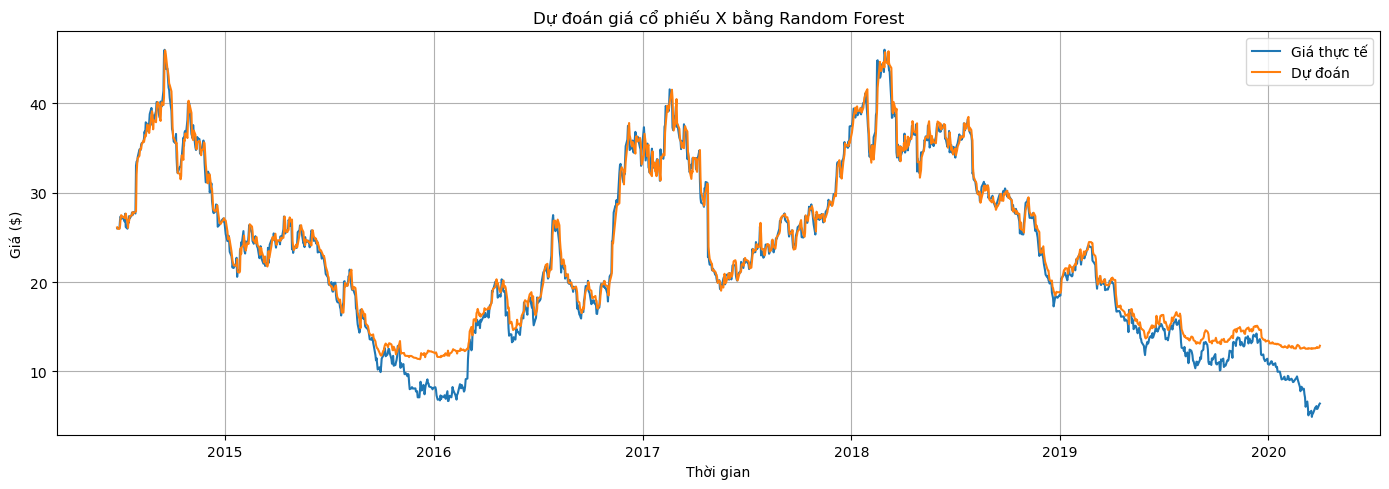

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test.values, label='Giá thực tế')
plt.plot(y_test.index, y_pred, label='Dự đoán')  # Cùng index với y_test
plt.legend()
plt.title(f'Dự đoán giá cổ phiếu {ticker} bằng Random Forest')
plt.xlabel("Thời gian")
plt.ylabel("Giá ($)")
plt.grid()
plt.tight_layout()
plt.show()
# plt.figure(figsize=(10, 6))
# indices = np.argsort(importances)[::-1]
# plt.bar(range(len(importances)), importances[indices])
# plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
# plt.title("Feature Importances (Random Forest)")
# plt.tight_layout()
# plt.show()

In [162]:
latest_data = X.tail(1)
next_price = model.predict(latest_data)
print(f"Dự đoán giá cổ phiếu {ticker} ngày kế tiếp: ${next_price[0]:.2f}")

Dự đoán giá cổ phiếu X ngày kế tiếp: $12.96
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=500; total time=   1.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   5.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.8s
